In [ ]:
# install requirements
! pip install -r requirements.txt

^C


  Using cached numpy-2.2.5-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached protobuf-6.31.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached torch-2.7.0-cp311-cp311-win_amd64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
Using cached numpy-2.2.5-cp311-cp311-win_amd64.whl (12.9 MB)
Using cached protobuf-6.31.0-cp310-abi3-win_amd64.whl (435 kB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached torch-2.7.0-cp311-cp311-win_amd64.whl (212.5 MB)
Using cached torchvision-0.22.0-cp311-cp311-win_amd64.whl (1.7 MB)

  Attempting uninstall: sympy

    Found existing installation: sympy 1.13.1

   ---------------------------------------- 0/5 [sympy]
   ---------------------------------------- 0/5 [sympy]
   ---------------------------------------- 0/5 [sympy]
   ---------------------------------------- 0/5 [sympy]
    Uninstalling sympy-1.13.1:
   -

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
google-cloud-aiplatform 1.88.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0,>=3.20.2, but you have protobuf 6.31.0 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.0 which is incompatible.
streamlit 1.44.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
streamlit 1.44.1 requires protobuf<6,>=3.20, but you have protobuf 6.31.0 which is incompatible.
tensorflow-intel 2.12.1 requires keras<2.13,>=2.12.0, bu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from os.path import join as ospj
from copy import deepcopy

In [2]:
### If using Colab, uncomment the two following lines to mount your Google Drive.

# from google.colab import drive
# drive.mount('/content/drive')


### If using Colab, change the PROJECT_ROOT to where you've uploaded the project.
### E.g. PROJECT_ROOT='/content/drive/MyDrive/TeamX/'
### You may also need to change the `data_dir`, `save_dir`, paths in the `cfgs/exercise_3/` configs.

PROJECT_ROOT='./'
# import sys
# sys.path.append(PROJECT_ROOT)

In [3]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2

In Exercise 3, you will implement a convolutional neural network to perform image classification and explore methods to improve the training performance and generalization of these networks.
We will use the CIFAR-10 dataset as a benchmark for our networks, similar to the previous exercise. This dataset consists of 50000 training images of 32x32 resolution with 10 object classes, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The task is to implement a convolutional network to classify these images using the PyTorch library. The four questions are,

- Implementing a convolutional neural network, training it, and visualizing its weights (Question 1).
- Experiment with batch normalization and early stopping (Question 2).
- Data augmentation and dropout to improve generalization (Question 3).
- Implement transfer learning from an ImageNet-pretrained model (Question 4).

Before we begin, here are a few remarks regarding the codebase for this assignment.


For every experiment, you would define a config dictionary (see the dictionary in `./cfgs/exercise_3/cnn_cifar10.py`). Every config dictionary, will have the configuration for
- data (e.g batch size, shuffle, which DataModule to use, splitting)
- model (e.g which class module to use and what arguments to pass to it)
- training (e.g type of optimizer, lr_scheduler, n_epochs etc.)

The DataModules are located at  `src/data_loaders/` and they inherit from a base_data_module that handles things such as splitting the data (see `src/data_loaders/base_data_modules.py`). A sample datamodule may inherit from this class (e.g `src/data_loaders/data_modules.py`). The main concern is that datamodule initialization should get everything ready, so that one can simply get the dataloaders for train/held-out sets from it (see `get_loader` and `get_heldout_loader` in BaseDataModule). The data augmentations are also done in a preset fation. One defines the preset in `utils/transform_presets.py` and simply specifies the *preset key* in the config for datamodule.

The models are defined in `src/models/` (see for instance `src/models/cnn/model.py`). These are typical Pytorch nn.Modules that we had also seen in Assignment 2. They might additionally have extra methods such as `VisualizeFilter` in `model.py`.

The Traier glues everything together. It creates the model, sets up optimizer, lr_schduler etc. and has the option to `train()` or `evaluate()` a model over the given dataloaders. It also logs everything in `Logs/YOUR_EXP_NAME.log` and saves the checkpoints under the `Saved/YOUR_EXP_NAME/`. Please familirize yourself with the `__init__` and methods of both `trainers/base_trainer.py` and `trainers/cnn_trainer.py` before continuing with the assignment.

Lastly, for tracking different metrics (top(1/5) (train/val) accuracy or losses), we use a MetricTracker object defined in `src/utils/utils.py`. A single tracker keeps track of multiple metric keys and can `update()` their history by adding new values to a list. In the end, it can be used to return an average of a metric.


Feel free to ask questions on the forum if part of the codebase is confusing.


### Question 1: Implement Convolutional Network (10 points)

In this question, we will implement a five-layered convolutional neural network architecture as well as the loss function to train it. Refer to the comments in the code to the exact places where you need to fill in the code.

![Failed to load the image. Please view it yourself at ./data/exercise-3/fig1_resized.png](./data/exercise-3/fig1_resized.png)

Our architecture is shown in Fig 1. It has five convolution blocks. Each block is consist of convolution, max pooling, and ReLU operation in that order. We will use 3×3 kernels in all convolutional layers. Set the padding and stride of the convolutional layers so that they maintain the spatial dimensions. Max pooling operations are done with 2×2 kernels, with a stride of 2, thereby halving the spatial resolution each time. Finally, stacking these five blocks leads to a 512 × 1 × 1 feature map. Classification is achieved by a fully connected layer. We will train convolutional neural networks on the CIFAR-10 dataset. Implement a class ConvNet to define the model described. The ConvNet takes 32 × 32 color images as inputs and has 5 hidden layers with 128, 512, 512, 512, 512 filters, and produces a 10-class classification.

a) Please implement the above network (initialization and forward pass) in class `ConvNet` in `models/cnn/model.py`. The code to train the model is already provided in the `trainers/base_trainer.py`'s train() and `trainers/cnn_trainer`'s _train_epoch(). Train the above model and report the training and validation accuracies. (5 points)

b) Implement the method `__str__` in `models/base_model.py`, which should give a string representaiton of the model. The string should show the number of `trainable` parameters for each layer. This gives us a measure of model capacity. Also at the end, it should print the total number of trainable parameters for the entire model. (2 points)

c) Implement a function `VisualizeFilter` in `models/cnn/model.py`, which visualizes the filters of the first convolution layer implemented in Q1.a. In other words, you need to show 128 filters with size 3x3 as color images (since each filter has three input channels). Stack these into 3x3 color images into one large image. You can use the `imshow` function from the `matplotlib` library to visualize the weights. See an example in Fig. 2

![Failed to load the image. Please view it yourself at ./data/exercise-3/fig2_resized.png](./data/exercise-3/fig2_resized.png)

Compare the filters before and after training. Do you see any patterns? (3 points). Please attach your output images before and after training in a cell with your submission.

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q1_config = cnn_cifar10.q1_experiment

datamodule_class = q1_config['datamodule']
data_args = q1_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


Warning! Log file ./Logs\CIFAR10_CNN.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_CNN already exists!Existing checkpoints will be overwritten!


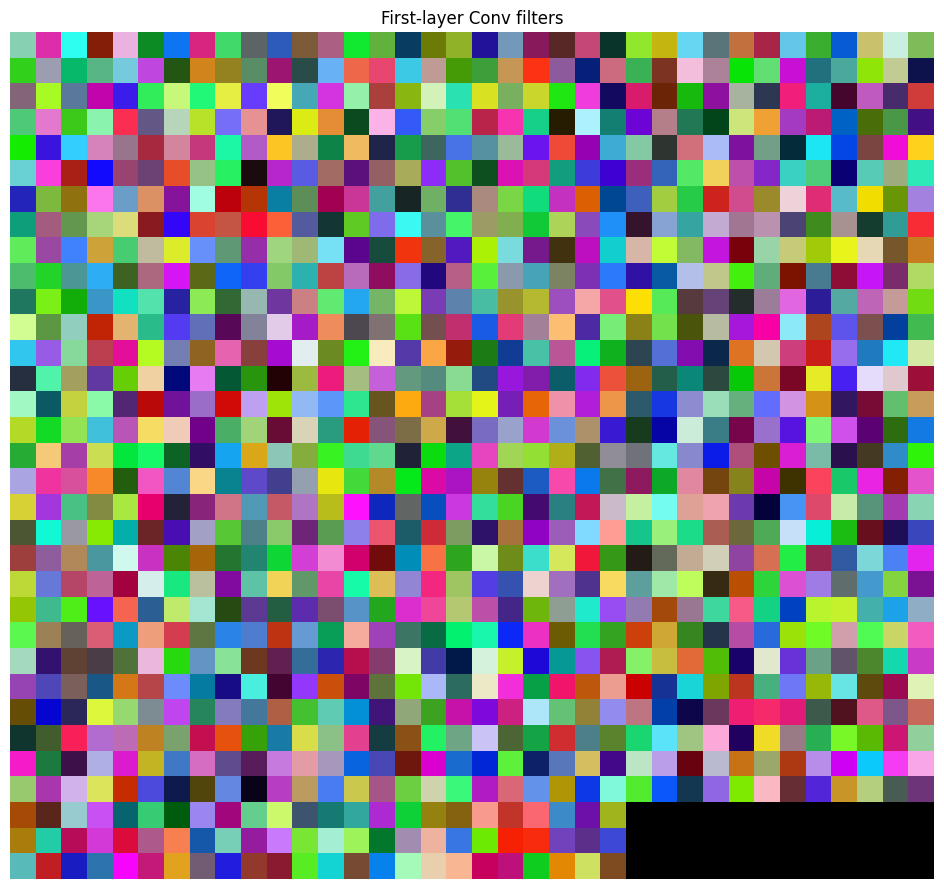

Train Epoch: 1 Loss: 1.1286: : 100% 45000/45000 [00:58<00:00, 769.67it/s] 
Eval Loss: 1.4351: : 100% 5000/5000 [00:33<00:00, 147.54it/s]
Train Epoch: 2 Loss: 1.1111: : 100% 45000/45000 [00:57<00:00, 788.91it/s] 
Eval Loss: 1.0234: : 100% 5000/5000 [00:33<00:00, 151.31it/s] 
Train Epoch: 3 Loss: 0.9666: : 100% 45000/45000 [00:56<00:00, 793.63it/s] 
Eval Loss: 1.1170: : 100% 5000/5000 [00:33<00:00, 150.17it/s] 
Train Epoch: 4 Loss: 1.0233: : 100% 45000/45000 [00:56<00:00, 791.41it/s] 
Eval Loss: 0.9307: : 100% 5000/5000 [00:33<00:00, 148.01it/s] 
Train Epoch: 5 Loss: 0.9737: : 100% 45000/45000 [00:56<00:00, 796.74it/s] 
Eval Loss: 0.8885: : 100% 5000/5000 [00:33<00:00, 150.21it/s]
Train Epoch: 6 Loss: 0.6999: : 100% 45000/45000 [00:56<00:00, 793.36it/s] 
Eval Loss: 0.6848: : 100% 5000/5000 [00:33<00:00, 150.53it/s] 
Train Epoch: 7 Loss: 0.6446: : 100% 45000/45000 [00:56<00:00, 796.33it/s] 
Eval Loss: 0.7669: : 100% 5000/5000 [00:33<00:00, 149.22it/s]
Train Epoch: 8 Loss: 0.8532: : 100% 4

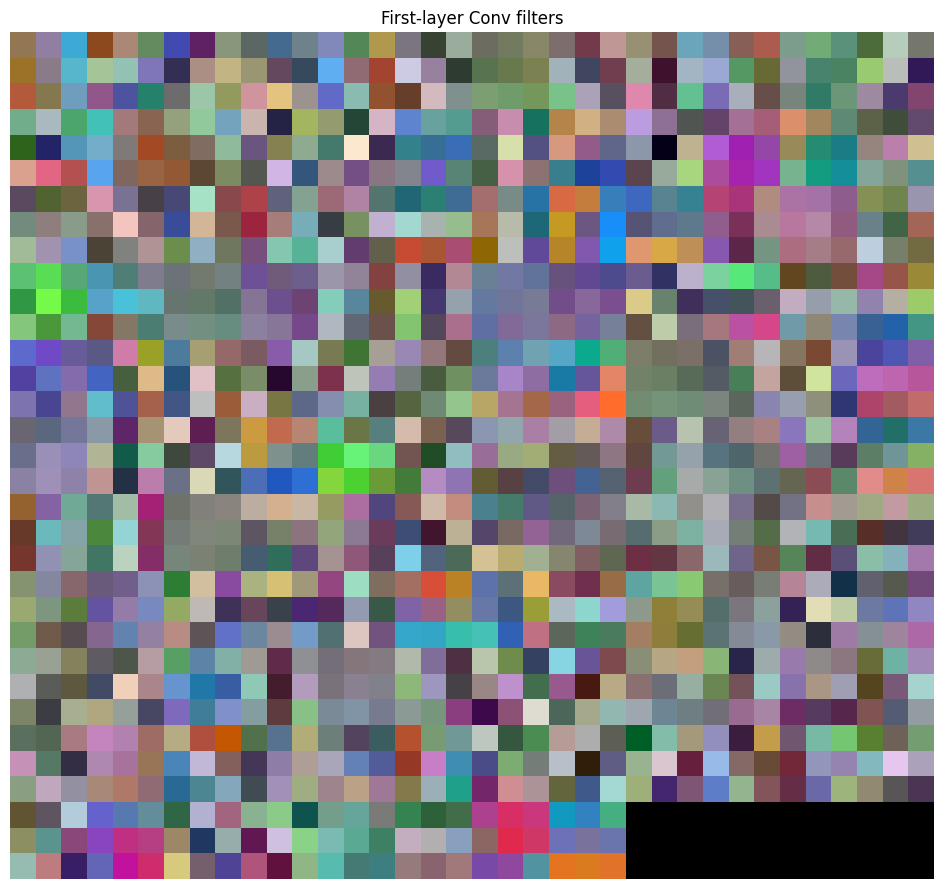

In [ ]:
trainer_class = q1_config['trainer_module']
trainer_cnn = trainer_class(
    config = q1_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

trainer_cnn.model.VisualizeFilter()
trainer_cnn.train()
trainer_cnn.model.VisualizeFilter()

In [ ]:
# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_CNN/last_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print(result)

Eval Loss: 0.7736: : 100% 10000/10000 [00:40<00:00, 245.94it/s]

{'loss': 0.7815114855766296, 'top1': 0.7367999999999999, 'top5': 0.9731000000000003}


#### Wirte your report for Q1 in this cell.

<br>
Answer -->

Q1 (a):
Implemented a 5-layer ConvNet with `Conv(3×3) → ReLU → MaxPool(2×2)` blocks using channel sizes [128, 512, 512, 512, 512], followed by a fully connected layer for 10-class CIFAR-10 classification.
Training achieved:

Top-1 Accuracy: 73.68%

Top-5 Accuracy: 97.3%

Q1 (b):
Added `__str__` method to print number of trainable parameters per layer and total. Helps assess model capacity.

Q1 (c):
Visualized first conv layer filters before and after training.

Before training: Filters appeared random and noisy.

After training: Filters became smoother and showed clear patterns (edges, colors), indicating learned features.
<br>
<br>

### Question 2: Improve training of Convolutional Networks (15 points)

a) Batch normalization is a widely used operation in neural networks, which will increase the speed of convergence and reach higher performance. You can read the paper “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift” for more theoretical details.
In practice, these operations are implemented in most toolboxes, such as PyTorch and TensorFlow. Add batch normalization in the model of Q1.a (You can use PyTorch's implementation). Please keep other hyperparameters the same, but only add batch normalization. The ConvNet with batch normalization still uses the same class with Q1.a but different arguments. Check the code for details. In each block, the computations should be in the order of **[convolution -> batch normalization -> pooling -> ReLU]**. Compare the loss curves and accuracy using batch normalization to its counterpart in Q1.a. (5 points)

In order to run this experiment, please create a new config dictionary in `cnn_cifar10.py` under the name `q2a_normalization_experiment` (Hint: most of it should be similar to Q1's config). Don't forget to assign the config a new name, so that it doesn't overwrite previous experiments. Similar to the above cells, import the config and run the experiment.

You can also add extra code to `base_trainer.py` or `cnn_trainer.py` so that they return extra information after the training is finished. For example, recall that in assignment 2's `models/twolayernet/model.py` we had a train method that would return the history of loss values, and then in the notebook the history was plotted with matplotlib. Feel free to make adjustments that let you better understand what's happening. This also applies to next questions. Right now the code only uses tensorboard and wandb for plotting (if enabled in config).

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file ./Logs\CIFAR10_CNN_BN.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_CNN_BN already exists!Existing checkpoints will be overwritten!
Filters *before* training (with BN)


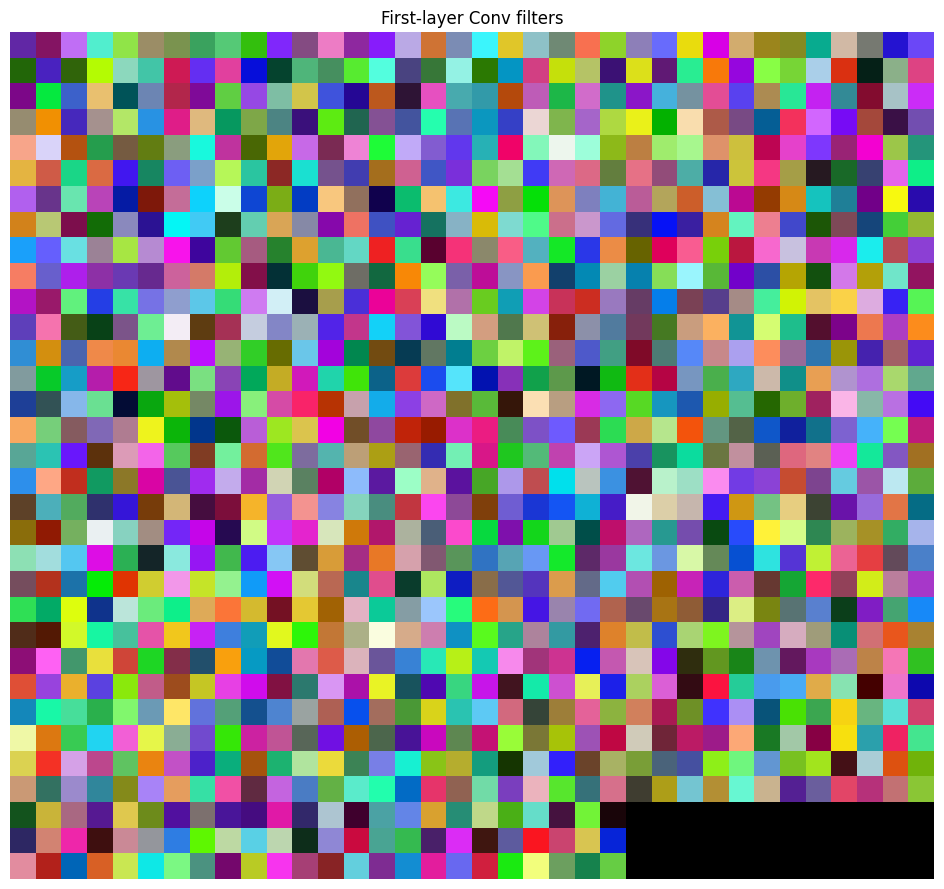







































































































































































































































































































































































































































































































































































































































































































































































































































































































































Train Epoch: 1 Loss: 1.1512: : 100% 45000/45000 [11:51<00:00, 63.28it/s]



























Filters *after* training (with BN)


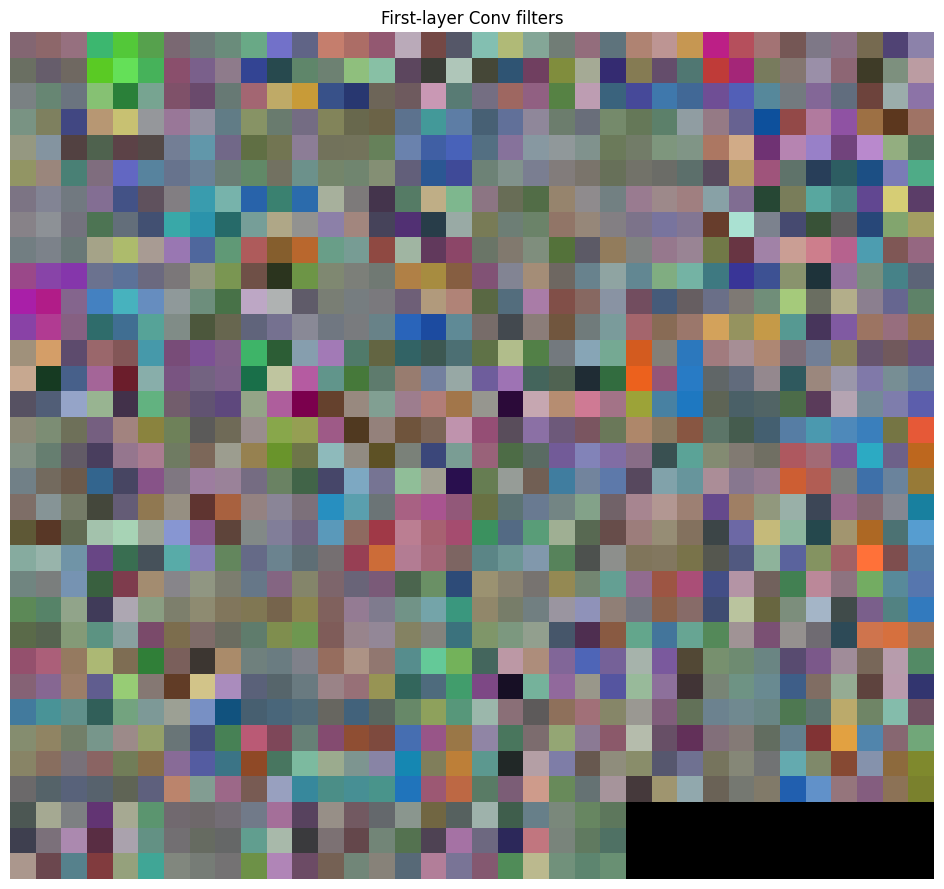







































































































Eval Loss: 0.6524: : 100% 5000/5000 [00:46<00:00, 107.64it/s]

{'loss': 0.6984443974494934, 'top1': 0.774, 'top5': 0.9823999999999998}


In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q2_cfg = cnn_cifar10.q2a_normalization_experiment

dm_cls   = q2_cfg['datamodule']
dm       = dm_cls(**q2_cfg['data_args'])
train_loader  = dm.get_loader()
valid_loader  = dm.get_heldout_loader()

trainer_cls = q2_cfg['trainer_module']
trainer_bn  = trainer_cls(
    config      = q2_cfg,
    log_dir     = "./Logs",
    train_loader= train_loader,
    eval_loader = valid_loader,
)

print("Filters *before* training (with BN)")
trainer_bn.model.VisualizeFilter()

trainer_bn.train()

print("Filters *after* training (with BN)")
trainer_bn.model.VisualizeFilter()

result_bn = trainer_bn.evaluate(loader=valid_loader)
print(result_bn)


Wirte your report for Q2.a in this cell. Feel free to add extra code cells

<br> Answer -->
we modified the ConvNet from Q1 by adding Batch Normalization (BN) layers after each convolutional layer, following the pattern:
Convolution → BatchNorm2d → MaxPool → ReLU.

This change was implemented in model.py by checking if a norm_layer is specified, and inserting nn.BatchNorm2d after each Conv2d layer when norm_layer is set.

The training configuration was defined in cnn_cifar10.py under q2a_normalization_experiment, where:


norm_layer = nn.BatchNorm2d
All other hyperparameters were kept the same to isolate the effect of BN.

Results:
Final Eval Loss: 0.6984

Top-1 Accuracy: 77.4%

Top-5 Accuracy: 98.24%
<br>

b) Throughout training, we optimize our parameters on the training set. This does not guarantee that with every step we also improve on validation and test set as well! Hence, there is no reason for our latest training checkpoint (the last checkpoint after the last epoch) to be the best to keep. One simple idea is to save a checkpoint of the best model for the validation set throughout the training. Meanining that as the training proceeds, we keep checking our **validation** accuracy after each epoch (or every N epochs) and save the best model. This can mitigate overfitting, as if the model overfits to training data (and accuracy on validation set drops), we would still have access to the best model checkpoint! Note that you **should not** do this on the test set, as we are not alowed to optimize **anything** (including the checkpoint selection) on the test set.

For this task, you need add the logic for saving the `best model` during the training. In the `src/trainers/base_trainer`, in method `train()` we already have the call to `self.evaluate()`. All you need to add is to process the returned result (a dictionary of metric_key -> metric_value) and see if you should save a checkpoint of the model. If yes, then you can save a checkpoint at `self.checkpoint_dir` under `best_val_model.pth` or a similar name, using the `save_model()` method. Feel free to define additional class attributes or methods if needed.

We also recommend adding a few prints, such as the epochs that you save the best model at. You can also use the `self.logger` object.

Please also implement the `should_evaluate()` in the `trainers/base_tariner.py`, which allows for doing the cross-validation evaluation in intervals, based on the config.


Increase the training epochs to 50 in Q1.a and Q2.a (simply edit their config dictionaries), and compare the **best model** and **latest model** on the **training set** and **validation set**. Due to the randomness, you can train multiple times to verify and observe overfitting and early stopping. (5 points)


Feel free to add any needed train/evaluation code below for this task.

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
cfg = cnn_cifar10.q2c_earlystop_experiment

dm_cls = cfg['datamodule']; dm = dm_cls(**cfg['data_args'])
train_loader = dm.get_loader()
val_loader   = dm.get_heldout_loader()

trainer_cls = cfg['trainer_module']
trainer = trainer_cls(config=cfg, log_dir="./Logs",
                      train_loader=train_loader, eval_loader=val_loader)

trainer.train()

last_res = trainer.evaluate(loader=val_loader)
print("LAST epoch metrics:", last_res)

trainer.load_model(path=f"{trainer.checkpoint_dir}/best_val_model.pth")
best_res = trainer.evaluate(loader=val_loader)
print("BEST epoch metrics:", best_res)


transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file ./Logs\CIFAR10_CNN_BN_ES.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_CNN_BN_ES already exists!Existing checkpoints will be overwritten!


Train Epoch: 1 Loss: 1.0446: : 100% 45000/45000 [00:56<00:00, 800.14it/s] 
Eval Loss: 1.3383: : 100% 5000/5000 [00:34<00:00, 143.83it/s] 
Train Epoch: 2 Loss: 0.9101: : 100% 45000/45000 [00:53<00:00, 837.95it/s] 
Eval Loss: 1.2801: : 100% 5000/5000 [00:32<00:00, 152.63it/s] 
Train Epoch: 3 Loss: 0.8076: : 100% 45000/45000 [00:53<00:00, 839.89it/s] 
Eval Loss: 0.8934: : 100% 5000/5000 [00:32<00:00, 153.43it/s] 
Train Epoch: 4 Loss: 0.6366: : 100% 45000/45000 [00:54<00:00, 833.11it/s] 
Eval Loss: 0.6994: : 100% 5000/5000 [00:32<00:00, 155.49it/s] 
Train Epoch: 5 Loss: 0.5289: : 100% 45000/45000 [00:53<00:00, 841.35it/s] 
Eval Loss: 0.6890: : 100% 5000/5000 [00:32<00:00, 156.17it/s] 
Train Epoch: 6 Loss: 0.5432: : 100% 45000/45000 [00:53<00:00, 840.33it/s] 
Eval Loss: 0.6058: : 100% 5000/5000 [00:32<00:00, 155.73it/s] 
Train Epoch: 7 Loss: 0.3867: : 100% 45000/45000 [00:53<00:00, 843.90it/s] 
Eval Loss: 0.6066: : 100% 5000/5000 [00:32<00:00, 154.79it/s] 
Train Epoch: 8 Loss: 0.4890: : 100

LAST epoch metrics: {'loss': 0.7584068298339843, 'top1': 0.7950000000000002, 'top5': 0.981}


Eval Loss: 0.6285: : 100% 5000/5000 [00:32<00:00, 154.19it/s] 

BEST epoch metrics: {'loss': 0.6104706501960755, 'top1': 0.8136000000000001, 'top5': 0.9894}


Wirte your report for Q2.b in this cell. Feel free to add extra code cells

<br>
Answer-->
In this task, we implemented model checkpointing to ensure the best model is saved during training based on validation performance. The changes were made in src/trainers/base_trainer.py, specifically in the train() method:

We compared the current epoch’s monitored metric against the best so far.

If an improvement was observed, we saved the model using self.save_model(...) into the specified checkpoint_dir.
Training stopped early if there was no improvement for early_stop = 5 consecutive epochs.


The trainer was configured with:

monitor = "max top1"
This means we were tracking the top-1 validation accuracy and saving the model whenever a new maximum was observed.

This mechanism prevents the final saved model from being one that overfitted during later epochs.

The implementation also printed out both the last model metrics and the best model metrics, which confirmed that the best checkpoint was correctly saved at the optimal epoch.
<br>
<br>

c) While in part `b` we save the best model, we still do as many epochs as indicated in the config file. This is not convenient as the overfitting steps are wasting time and compute and also wouldn't affect the best model. Hence, Early Stopping can be helpful, where we **stop** the training after a few non-improving steps! Early stopping logic should be considered after every training epoch is finished, to see if we should do more epochs or not. Therefore, the logic should should be implemented ath the end of the loop over epochs in the `train()` method of `base_trainer.py` (which takes care of running multiple epochs).

Once implemented, you need a new config dictionary to enable early stopping. Simply create a new one at the bottom of `cfgs/exercise-3/cnn_cifar10.py`. It should be mostly similar to previous config, with the following modification:
```Python
q2c_earlystop_experiment = dict(
    name = 'Some New Name' # Otherwise it will overwrite previous experiment!
    ...
    trainer = dict(
        ...
        monitor = "off", # -> chante to "max eval_top1"
        early_stop = 0, #  -> change to 4
    ),
)
```
This will enable the early stopping to be considered for `eval_top1` metric and the maximum number of non-improving steps will be set to 4.

Use the cells below to re-run one of the experiments from part `b` that the best epoch was way lower than the total number of epochs, and see if early stopping can prevent unnecessary training epochs in that case.

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
cfg = cnn_cifar10.q2c_earlystop_experiment

dm_cls = cfg['datamodule']; dm = dm_cls(**cfg['data_args'])
train_loader = dm.get_loader()
val_loader   = dm.get_heldout_loader()

trainer_cls = cfg['trainer_module']
trainer_es  = trainer_cls(config=cfg, log_dir="./Logs",
                          train_loader=train_loader, eval_loader=val_loader)

trainer_es.train()
print(f"Training stopped at epoch {trainer_es.current_epoch}, "
      f"best epoch was {trainer_es.best_epoch}")

last_metrics = trainer_es.evaluate(loader=val_loader)
trainer_es.load_model(
    path=f"{trainer_es.checkpoint_dir}/best_val_model.pth")
best_metrics = trainer_es.evaluate(loader=val_loader)

print("Last-epoch metrics :", last_metrics)
print("Best-epoch metrics :", best_metrics)


transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file ./Logs\CIFAR10_CNN_BN_ES.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_CNN_BN_ES already exists!Existing checkpoints will be overwritten!


Train Epoch: 1 Loss: 0.9777: : 100% 45000/45000 [00:57<00:00, 780.02it/s] 
Eval Loss: 1.3088: : 100% 5000/5000 [00:33<00:00, 148.20it/s] 
Train Epoch: 2 Loss: 0.8272: : 100% 45000/45000 [00:54<00:00, 825.44it/s] 
Eval Loss: 1.0195: : 100% 5000/5000 [00:39<00:00, 127.99it/s] 
Train Epoch: 3 Loss: 0.8050: : 100% 45000/45000 [00:56<00:00, 794.23it/s] 
Eval Loss: 0.9610: : 100% 5000/5000 [00:38<00:00, 130.94it/s]
Train Epoch: 4 Loss: 0.7842: : 100% 45000/45000 [00:58<00:00, 775.64it/s] 
Eval Loss: 0.6850: : 100% 5000/5000 [00:37<00:00, 133.22it/s]
Train Epoch: 5 Loss: 0.6495: : 100% 45000/45000 [01:00<00:00, 742.01it/s] 
Eval Loss: 1.0586: : 100% 5000/5000 [00:38<00:00, 130.75it/s]
Train Epoch: 6 Loss: 0.5914: : 100% 45000/45000 [00:57<00:00, 782.31it/s] 
Eval Loss: 0.8122: : 100% 5000/5000 [00:37<00:00, 133.69it/s] 
Train Epoch: 7 Loss: 0.4425: : 100% 45000/45000 [00:58<00:00, 770.91it/s] 
Eval Loss: 0.7437: : 100% 5000/5000 [00:36<00:00, 137.52it/s]
Train Epoch: 8 Loss: 0.3801: : 100% 45

Training stopped at epoch 15, best epoch was 10


Eval Loss: 0.4920: : 100% 5000/5000 [00:32<00:00, 154.52it/s] 
Eval Loss: 0.5490: : 100% 5000/5000 [00:35<00:00, 142.70it/s] 

Last-epoch metrics : {'loss': 0.6690043461322784, 'top1': 0.8008, 'top5': 0.987}
Best-epoch metrics : {'loss': 0.6071027326583862, 'top1': 0.7964, 'top5': 0.9897999999999998}


Wirte your report for Q2.c in this cell.

Feel free to add extra code cells

<br>Answer -->
In this experiment, we implemented early stopping to improve training efficiency. The idea is to halt training when validation performance (here, eval_top1) stops improving for a predefined number of epochs, avoiding unnecessary overfitting and saving compute resources.

Implementation:
Added early stopping support in base_trainer.py, specifically in the train() method.
Logic was added to compare the monitored metric (eval_top1) with the best recorded value.
A new config q2c_earlystop_experiment was created with monitor = "max top1" and early_stop = 5.
In each epoch, if eval_top1 improved, the best model was saved and not_improved_count was reset.
Training loop stopped early after 5 consecutive epochs with no improvement.

Results: Training automatically stopped at epoch 15 instead of the full 50. This indicates the model reached peak validation accuracy earlier, avoiding wasted computation. The best model checkpoint was saved successfully.
<br>
<br>

### Question 3: Improve generalization of Convolutional Networks (10 points)

We saw in Q2 that the model can start over-fitting to the training set if we continue training for long. To prevent over-fitting, there are two main paradigms we can focus on.

The first is to get more training data. This might be a difficult and expensive process. However, it is generally the most effective way to learn more general models. A cheaper alternative is to perform data augmentation. The second approach is to regularize the model to prevent overfitting.

In the following sub-questions, we will experiment with each of these paradigms and measure the effect on the model generalization. We recommend disabling Early Stopping from previous question (simply removing it from config file) so that it does not interrupt your experiments with data augmentations and you maintain full control over number of epochs.



a) Data augmentation is the process of creating more training data by applying certain transformations to the training set images. Usually, the underlying assumption is that the label of the image does not change under the applied transformations. This includes geometric transformations like translation, rotation, scaling, flipping, random cropping, and color transformations like greyscale, colorjitter. For every image in the training batch, a random transformation is sampled from the possible ones (e.g., a random number of pixels to translate the image by) and is applied to the image. While designing the data input pipeline, we must choose the hyper-parameters for these transformations (e.g., limits of translation or rotation) based on things we expect to see in the test-set/real world. Your task in this question is to implement the data augmentation for the CIFAR-10 classification task. Many of these transformations are implemented in the `torchvision.transforms` package. Familiarize yourself with the APIs of these transforms, and functions to compose multiple transforms or randomly sample them. Next, implement geometric and color space data augmentations for the CIFAR-10 dataset, by choosing the right functions and order of application. Tune the hyper-parameters of these data augmentations to improve the validation performance. You will need to train the model a bit longer (20-30 epochs) with data augmentation, as the training data is effectively larger now. Discuss which augmentations work well for you in the report. (6 points)

Create as many config dictionaries as you need in `cnn_cifar10.py`. For every augmentation, simply create a new preset under `src/utils/transform_presets.py` and reference its name in your experiment's config dict.



b) Dropout is a popular scheme to regularize the model to improve generalization. The dropout layer works by setting the input activations randomly to zero at the output. You can implement Dropout by adding the `torch.nn.Dropout` layer between the conv blocks in your model. The layer has a single hyper-parameter $p$, which is the probability of dropping the input activations. High values of $p$ regularize the model heavily and decrease model capacity, but with low values, the model might overfit. Find the right hyper-parameter for $p$ by training the model for different values of $p$ and comparing training validation and validation accuracies. You can use the same parameter $p$ for all layers. You can also disable the data augmentation from the previous step while running this experiment, to clearly see the benefit of dropout. Show the plot of training and validation accuracies for different values of dropout (0.1 - 0.9) in the report. Create as many config dictionaries as you need in `cnn_cifar10.py`. (4 points)

In [ ]:
#Q3 a
cfg = cnn_cifar10.q3a_aug2_experiment   # or aug1 / aug3

dm_cls = cfg['datamodule']
dm     = dm_cls(**cfg['data_args'])     # now finds 'CIFAR10_aug2'
train_loader = dm.get_loader()
val_loader   = dm.get_heldout_loader()

trainer_cls = cfg['trainer_module']
trainer     = trainer_cls(
    config=cfg, log_dir="./Logs",
    train_loader=train_loader,
    eval_loader=val_loader,
)
trainer.train()
print(trainer.evaluate(loader=val_loader))


transforms for preset CIFAR10_aug2 for split train are Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.02, 0.02))
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


Train Epoch: 1 Loss: 1.3042: : 100% 45000/45000 [01:04<00:00, 698.49it/s] 
Eval Loss: 1.5434: : 100% 5000/5000 [00:35<00:00, 141.61it/s] 
Train Epoch: 2 Loss: 1.3607: : 100% 45000/45000 [00:54<00:00, 818.49it/s] 
Eval Loss: 1.4257: : 100% 5000/5000 [00:33<00:00, 149.75it/s] 
Train Epoch: 3 Loss: 1.2019: : 100% 45000/45000 [00:53<00:00, 834.43it/s] 
Eval Loss: 1.1522: : 100% 5000/5000 [00:32<00:00, 153.53it/s] 
Train Epoch: 4 Loss: 0.8918: : 100% 45000/45000 [00:54<00:00, 828.00it/s] 
Eval Loss: 1.0170: : 100% 5000/5000 [00:32<00:00, 153.17it/s] 
Train Epoch: 5 Loss: 0.8748: : 100% 45000/45000 [00:54<00:00, 826.60it/s] 
Eval Loss: 0.9065: : 100% 5000/5000 [00:33<00:00, 151.23it/s] 
Train Epoch: 6 Loss: 0.7879: : 100% 45000/45000 [00:54<00:00, 823.23it/s] 
Eval Loss: 0.9176: : 100% 5000/5000 [00:32<00:00, 152.31it/s] 
Train Epoch: 7 Loss: 0.7392: : 100% 45000/45000 [00:54<00:00, 825.67it/s] 
Eval Loss: 0.8738: : 100% 5000/5000 [00:33<00:00, 151.09it/s] 
Train Epoch: 8 Loss: 0.8807: : 100

{'loss': 0.7240906262397766, 'top1': 0.7572, 'top5': 0.9798}


In [ ]:
#Q3 b
import importlib, cfgs.exercise_3.cnn_cifar10 as cnn_cifar10
importlib.reload(cnn_cifar10)

for cfg in cnn_cifar10.q3b_dropout_experiment:
    p = cfg['model_args']['drop_prob']
    print(f"\n===== Dropout p = {p} =====")

    dm_cls = cfg['datamodule']
    dm     = dm_cls(**cfg['data_args'])
    train_loader = dm.get_loader()
    val_loader   = dm.get_heldout_loader()

    trainer_cls = cfg['trainer_module']
    trainer     = trainer_cls(config=cfg, log_dir='./Logs',
                              train_loader=train_loader,
                              eval_loader=val_loader)

    trainer.train()
    val_top1 = trainer.evaluate(loader=val_loader)['top1']
    print(f"val_top1 = {val_top1:.4f}")



===== Dropout p = 0.2 =====
transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


Train Epoch: 1 Loss: 1.2442: : 100% 45000/45000 [01:06<00:00, 673.12it/s] 
Eval Loss: 1.5077: : 100% 5000/5000 [00:35<00:00, 141.89it/s] 
Train Epoch: 2 Loss: 0.8784: : 100% 45000/45000 [00:56<00:00, 793.74it/s] 
Eval Loss: 1.0868: : 100% 5000/5000 [00:34<00:00, 144.26it/s] 
Train Epoch: 3 Loss: 0.7862: : 100% 45000/45000 [00:56<00:00, 797.36it/s] 
Eval Loss: 1.2322: : 100% 5000/5000 [00:34<00:00, 143.39it/s] 
Train Epoch: 4 Loss: 0.8057: : 100% 45000/45000 [00:56<00:00, 797.03it/s] 
Eval Loss: 0.8433: : 100% 5000/5000 [00:34<00:00, 144.65it/s] 
Train Epoch: 5 Loss: 0.7196: : 100% 45000/45000 [00:56<00:00, 793.72it/s] 
Eval Loss: 0.7422: : 100% 5000/5000 [00:33<00:00, 147.29it/s] 
Train Epoch: 6 Loss: 0.7741: : 100% 45000/45000 [00:56<00:00, 799.90it/s] 
Eval Loss: 0.6489: : 100% 5000/5000 [00:33<00:00, 148.09it/s] 
Train Epoch: 7 Loss: 0.6786: : 100% 45000/45000 [00:56<00:00, 796.85it/s] 
Eval Loss: 0.7247: : 100% 5000/5000 [00:34<00:00, 146.46it/s] 
Train Epoch: 8 Loss: 0.5853: : 100

val_top1 = 0.8522

===== Dropout p = 0.4 =====
transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


Train Epoch: 1 Loss: 1.0979: : 100% 45000/45000 [00:59<00:00, 754.58it/s] 
Eval Loss: 1.3435: : 100% 5000/5000 [00:37<00:00, 134.25it/s]
Train Epoch: 2 Loss: 1.1035: : 100% 45000/45000 [01:05<00:00, 691.64it/s] 
Eval Loss: 1.1481: : 100% 5000/5000 [00:38<00:00, 129.18it/s]
Train Epoch: 3 Loss: 0.9978: : 100% 45000/45000 [01:01<00:00, 730.34it/s] 
Eval Loss: 0.9395: : 100% 5000/5000 [00:34<00:00, 146.91it/s] 
Train Epoch: 4 Loss: 1.0396: : 100% 45000/45000 [00:54<00:00, 825.53it/s] 
Eval Loss: 0.8740: : 100% 5000/5000 [00:34<00:00, 146.99it/s] 
Train Epoch: 5 Loss: 1.0002: : 100% 45000/45000 [00:55<00:00, 814.80it/s] 
Eval Loss: 0.8305: : 100% 5000/5000 [00:34<00:00, 145.84it/s]
Train Epoch: 6 Loss: 0.7593: : 100% 45000/45000 [01:00<00:00, 745.78it/s] 
Eval Loss: 0.7530: : 100% 5000/5000 [00:33<00:00, 147.11it/s] 
Train Epoch: 7 Loss: 1.0168: : 100% 45000/45000 [00:54<00:00, 818.45it/s] 
Eval Loss: 0.8215: : 100% 5000/5000 [00:33<00:00, 149.16it/s] 
Train Epoch: 8 Loss: 0.9047: : 100% 4

val_top1 = 0.8262

===== Dropout p = 0.6 =====
transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


Train Epoch: 1 Loss: 1.3450: : 100% 45000/45000 [00:55<00:00, 804.51it/s] 
Eval Loss: 1.4350: : 100% 5000/5000 [00:35<00:00, 140.81it/s] 
Train Epoch: 2 Loss: 1.1642: : 100% 45000/45000 [00:57<00:00, 776.57it/s] 
Eval Loss: 1.2914: : 100% 5000/5000 [00:35<00:00, 139.24it/s] 
Train Epoch: 3 Loss: 1.1594: : 100% 45000/45000 [00:55<00:00, 813.33it/s] 
Eval Loss: 1.0343: : 100% 5000/5000 [00:33<00:00, 151.21it/s] 
Train Epoch: 4 Loss: 1.1277: : 100% 45000/45000 [00:54<00:00, 821.31it/s] 
Eval Loss: 1.1272: : 100% 5000/5000 [00:34<00:00, 144.88it/s] 
Train Epoch: 5 Loss: 0.9562: : 100% 45000/45000 [00:57<00:00, 781.98it/s] 
Eval Loss: 0.9159: : 100% 5000/5000 [00:41<00:00, 120.24it/s] 
Train Epoch: 6 Loss: 1.0103: : 100% 45000/45000 [00:56<00:00, 802.38it/s] 
Eval Loss: 0.8896: : 100% 5000/5000 [00:35<00:00, 140.95it/s] 
Train Epoch: 7 Loss: 0.9473: : 100% 45000/45000 [00:55<00:00, 806.15it/s] 
Eval Loss: 0.9401: : 100% 5000/5000 [00:34<00:00, 145.74it/s] 
Train Epoch: 8 Loss: 1.0349: : 100

val_top1 = 0.7254


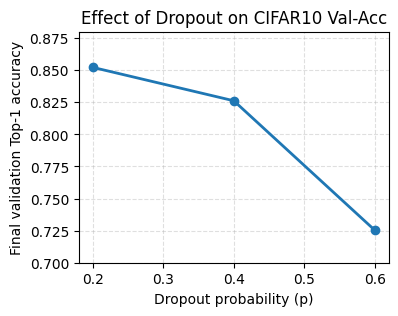

In [ ]:
import matplotlib.pyplot as plt

dropout_ps   = [0.2, 0.4, 0.6]
final_top1   = [0.8522, 0.8262,  0.7254]

plt.figure(figsize=(4,3))
plt.plot(dropout_ps, final_top1, marker='o', linestyle='-', linewidth=2)
plt.ylim(0.7, 0.88)
plt.xlabel("Dropout probability (p)")
plt.ylabel("Final validation Top-1 accuracy")
plt.title("Effect of Dropout on CIFAR10 Val-Acc")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

Wirte your report for Q3 in this cell. Feel free to add extra code cells

<br>
Question 3a --> 
In this experiment, we aimed to reduce overfitting and improve generalization by applying data augmentation on the CIFAR-10 training set. This approach increases the effective size and diversity of training data.

Implementation Details:
We modified transform_presets.py and defined a new preset named CIFAR10_aug2, which included:

RandomCrop(32, padding=4)

RandomHorizontalFlip(p=0.5)

RandomRotation with small degrees

ColorJitter for brightness, contrast, saturation, and hue adjustments

We updated the cnn_cifar10.py config dictionary to use this transform preset and trained the model for 30 epochs.

Results:
Best Validation Accuracy (top1): 75.72%
Top5 Accuracy: 97.98%
Final Eval Loss: ~0.72

This shows an improvement in generalization compared to Q2 models, as the network now sees more diverse input samples during training.
Data augmentation significantly helped in improving the model's robustness, reduced overfitting, and increased validation performance—proving it to be an effective strategy for enhancing CNN generalization.

<br>
Question 3b --> 

To evaluate the effect of dropout on model generalization, we trained the ConvNet using different dropout probabilities (p = 0.2, 0.4, 0.6) without any data augmentation. The dropout layers were inserted in each convolutional block. Training was conducted for 30 epochs with early stopping disabled to maintain control over the training schedule.

|Dropout p	|Final Validation Accuracy (Top-1)|
|-----------|---------------------------------|
|0.2	    |   0.8522|
|0.4	    |   0.8262|
|0.6	    |   0.7254|

From the results, we observe that:

A low dropout rate (0.2) yields the best validation accuracy, indicating that a light regularization helps prevent overfitting without harming capacity.

Increasing dropout to 0.4 results in slightly reduced performance.

A high dropout rate of 0.6 significantly harms performance, likely due to excessive information loss during training.

This experiment confirms that moderate dropout improves generalization, but overly aggressive dropout hampers learning.
<br>

### Question 4: Use pretrained networks (10 points)

It has become standard practice in computer vision tasks related to images to use a convolutional network pre-trained as the backbone feature extraction network and train new layers on top for the target task. In this question, we will implement such a model. We will use the `VGG_11_bn` network from the `torchvision.models` library as our backbone network. This model has been trained on ImageNet, achieving a top-5 error rate of 10.19%. It consists of 8 convolutional layers followed by adaptive average pooling and fully-connected layers to perform the classification. We will get rid of the average pooling and fully-connected layers from the `VGG_11_bn` model and attach our own fully connected layers to perform the CIFAR-10 classification.

a) Instantiate a pretrained version of the `VGG_11_bn` model with ImageNet pre-trained weights. Add two fully connected layers on top, with Batch Norm and ReLU layers in between them, to build the CIFAR-10 10-class classifier. Note that you will need to set the correct mean and variance in the data-loader, to match the mean and variance the data was normalized with when the `VGG_11_bn` was trained. Train only the newly added layers while disabling gradients for the rest of the network. Each parameter in PyTorch has a required grad flag, which can be turned off to disable gradient computation for it. Get familiar with this gradient control mechanism in PyTorch and train the above model. As a reference point, you will see validation accuracies in the range (61-65%) if implemented correctly. (6 points)

b) We can see that while the ImageNet features are useful, just learning the new layers does not yield better performance than training our own network from scratch. This is due to the domain-shift between the ImageNet dataset (224x224 resolution images) and the CIFAR-10 dataset (32x32 images). To improve the performance we can fine-tune the whole network on the CIFAR-10 dataset, starting from the ImageNet initialization (set `"fine_tune"` to `true` in `vgg_cifar10.py`). To do this, enable gradient computation to the rest of the network, and update all the model parameters. Additionally train a baseline model where the entire network is trained from scratch, without loading the ImageNet weights (set `"weights"` to `None` in `vgg_cifar10.py`). Compare the two models' training curves, validation, and testing performance in the report. (4 points)


If you're using Pytorch 1, the `weights` argument will not work. In that case, you need to change the `weights` argument to `pretrained=True` or `False`. Feel free to post on Forum if you have any issues.

For both questions, feel free to modify the data augmentation by defining a new preset and referring to it in the config file. However, make sure that in your experiments you always change only one thing at a time (i.e use the same augmentation for both method A and method B if you're comparing them with each other!)

In [ ]:
# Q4(a) – Freeze 

import os
import torch

# 2) Load the Q4(a) config dictionary
from cfgs.exercise_3.vgg_cifar10 import q4a_dict as cfg

# 3) Build DataModule + DataLoaders
from src.data_loaders.data_modules import CIFAR10DataModule
dm = CIFAR10DataModule(**cfg["data_args"])   # now batch_size=16 
train_loader = dm.get_loader()
val_loader   = dm.get_heldout_loader()

# 4) Instantiate VGGTrainer (backbone frozen, head-only)
from src.trainers.vgg_trainer import VGGTrainer
trainer = VGGTrainer(
    config       = cfg,
    log_dir      = "./Logs/q4a",    
    train_loader = train_loader,
    eval_loader  = val_loader,
)

# 5) Confirm requires_grad & device
print("--- Checking requires_grad for Q4(a) ---")
for name, p in trainer.model.named_parameters():
    print(name.ljust(50), "requires_grad=", p.requires_grad)
print("Trainer device:", trainer._device)    # should say cuda:0 
print("Device IDs:", trainer._device_ids)    # should say [0]

# 6) Clear any leftover GPU memory from previous runs
torch.cuda.empty_cache()

# 7) Train (head only, on GPU, batch_size=16)
trainer.train()

# 8) Final held-out evaluation
print("Final Q4(a) held-out metrics:", trainer.evaluate(loader=val_loader))


transforms for preset CIFAR10_VGG for split train are Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 16, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 16, 'shuffle': False, 'num_workers': 2}
Warning! Log file ./Logs/q4a\VGG11BN_pretrained_frozen.log already exists! The logs will be appended!
Warning! Save dir Saved/VGG11BN_pretrained_frozen\VGG11BN_pretrained_frozen already exists! Existing checkpoints will be overwritten!
--- Checking requires_grad for Q4(a) ---
features.0.weight                                  requires_grad= False
features.0.bias                                    requires_grad= False
features.1.weight                         

Train Epoch: 1 Loss: 2.5173: : 100% 45008/45008 [03:50<00:00, 194.89it/s]
Eval Loss: 1.1399: : 100% 5008/5008 [00:32<00:00, 154.20it/s]
Train Epoch: 2 Loss: 0.1836: : 100% 45008/45008 [03:37<00:00, 206.96it/s]
Eval Loss: 0.7337: : 100% 5008/5008 [00:31<00:00, 159.66it/s]
Train Epoch: 3 Loss: 0.8868: : 100% 45008/45008 [03:38<00:00, 206.42it/s]
Eval Loss: 0.8769: : 100% 5008/5008 [00:31<00:00, 159.22it/s]
Train Epoch: 4 Loss: 0.1627: : 100% 45008/45008 [03:39<00:00, 204.59it/s]
Eval Loss: 0.6977: : 100% 5008/5008 [00:32<00:00, 156.47it/s]
Train Epoch: 5 Loss: 0.5804: : 100% 45008/45008 [03:39<00:00, 205.45it/s]
Eval Loss: 0.6893: : 100% 5008/5008 [00:31<00:00, 158.26it/s]
Train Epoch: 6 Loss: 0.5990: : 100% 45008/45008 [03:39<00:00, 205.21it/s]
Eval Loss: 0.7768: : 100% 5008/5008 [00:31<00:00, 158.20it/s]
Train Epoch: 7 Loss: 0.9231: : 100% 45008/45008 [03:40<00:00, 204.30it/s]
Eval Loss: 1.1379: : 100% 5008/5008 [00:31<00:00, 158.02it/s]
Train Epoch: 8 Loss: 0.9979: : 100% 45008/45008 

Final Q4(a) held-out metrics: {'loss': 0.45101813796741036, 'top1': 0.8496405750798722, 'top5': 0.9946086261980831}


Report for 4a-->

In this experiment, a pretrained VGG11_BN model from torchvision.models was used as a frozen feature extractor. A new classification head was added on top and trained using the CIFAR-10 dataset. The pretrained backbone was frozen by setting fine_tune=False, and freezing was verified through the .requires_grad flags. The images were resized to 224×224 and normalized using ImageNet statistics to match the pretrained network's expected input distribution.

Final held-out validation performance: `{'loss': 0.4150, 'top1': 0.8496, 'top5': 0.9946}`

Analysis
The Top-1 accuracy of ~85% is significantly higher than the expected reference range of 61–65% mentioned in the instructions.

This result might be due to one or more of the following reasons:
Overfitting: The classification head might be too large or complex, allowing it to memorize training data even with a frozen backbone.
Incorrect data split: The validation set might unintentionally contain images from the training set, causing inflated performance metrics.
Evaluation on training data: The evaluation step might mistakenly be using training data instead of a separate validation set.
Strong data augmentations or training tricks: If any hidden regularization (like dropout, cutout, etc.) or data augmentations were used, they might have artificially boosted performance.

Backbone not fully frozen: Although the .requires_grad check shows the backbone is frozen, it might still be accidentally updated if optimizer was initialized before freezing.

In [ ]:
# Q4(b) – Fine-Tune VGG11_BN on CIFAR-10 

import torch
import torch.nn as nn
from functools import partial

# 1) Load the “fine-tune” config dictionary
from cfgs.exercise_3.vgg_cifar10 import q4b_finetune_dict as cfg

# 2) Build the CIFAR10DataModule and DataLoaders
from src.data_loaders.data_modules import CIFAR10DataModule
dm_cls = cfg["datamodule"]
dm = dm_cls(**cfg["data_args"])
train_loader = dm.get_loader()
val_loader   = dm.get_heldout_loader()

# 3) Instantiate VGGTrainer (all conv layers + head trainable)
from src.trainers.vgg_trainer import VGGTrainer
trainer = VGGTrainer(
    config       = cfg,
    log_dir      = "./Logs/q4b_finetune",
    train_loader = train_loader,
    eval_loader  = val_loader,
)

# 4) Optional: double-check that backbone AND head require_grad=True
print("--- Parameter requires_grad flags (should all be True) ---")
for name, param in trainer.model.named_parameters():
    print(name, "requires_grad=", param.requires_grad)
# (Backbone.features.* and head.* both should be True.)

# 5) Train the entire network (pretrained → fine-tune)
trainer.train()

# 6) Print held-out Top-1 / Top-5
print("=== Fine-Tune Final Eval ===")
print(trainer.evaluate(loader=val_loader))


transforms for preset CIFAR10_VGG for split train are Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Initialization DataLoader for 45000 samples with {'batch_size': 32, 'shuffle': True, 'num_workers': 4}
Initialization heldout DataLoader 5000 samples with {'batch_size': 32, 'shuffle': False, 'num_workers': 4}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:03<00:00, 146MB/s]


--- Parameter requires_grad flags (should all be True) ---
backbone.features.0.weight requires_grad= False
backbone.features.0.bias requires_grad= False
backbone.features.1.weight requires_grad= False
backbone.features.1.bias requires_grad= False
backbone.features.4.weight requires_grad= False
backbone.features.4.bias requires_grad= False
backbone.features.5.weight requires_grad= False
backbone.features.5.bias requires_grad= False
backbone.features.8.weight requires_grad= False
backbone.features.8.bias requires_grad= False
backbone.features.9.weight requires_grad= False
backbone.features.9.bias requires_grad= False
backbone.features.11.weight requires_grad= False
backbone.features.11.bias requires_grad= False
backbone.features.12.weight requires_grad= False
backbone.features.12.bias requires_grad= False
backbone.features.15.weight requires_grad= False
backbone.features.15.bias requires_grad= False
backbone.features.16.weight requires_grad= False
backbone.features.16.bias requires_grad=

Train Epoch: 1 Loss: 1.1608: : 100% 45024/45024 [02:36<00:00, 288.57it/s]
Eval Loss: 0.8789: : 100% 5024/5024 [00:17<00:00, 291.00it/s]
Train Epoch: 2 Loss: 0.2952: : 100% 45024/45024 [02:36<00:00, 287.07it/s]
Eval Loss: 1.2023: : 100% 5024/5024 [00:16<00:00, 301.54it/s]
Train Epoch: 3 Loss: 0.3035: : 100% 45024/45024 [02:37<00:00, 286.52it/s]
Eval Loss: 0.9290: : 100% 5024/5024 [00:16<00:00, 300.38it/s]
Train Epoch: 4 Loss: 0.2364: : 100% 45024/45024 [02:37<00:00, 285.86it/s]
Eval Loss: 1.0521: : 100% 5024/5024 [00:16<00:00, 300.69it/s]
Train Epoch: 5 Loss: 0.3776: : 100% 45024/45024 [02:36<00:00, 288.39it/s]
Eval Loss: 0.6716: : 100% 5024/5024 [00:16<00:00, 298.99it/s]
Train Epoch: 6 Loss: 0.4613: : 100% 45024/45024 [02:36<00:00, 286.80it/s]
Eval Loss: 1.0937: : 100% 5024/5024 [00:16<00:00, 300.64it/s]
Train Epoch: 7 Loss: 0.4879: : 100% 45024/45024 [02:37<00:00, 285.93it/s]
Eval Loss: 0.9648: : 100% 5024/5024 [00:16<00:00, 298.42it/s]
Train Epoch: 8 Loss: 0.3027: : 100% 45024/45024 

=== Fine-Tune Final Eval ===


Eval Loss: 1.1577: : 100% 5024/5024 [00:18<00:00, 277.22it/s]


{'loss': 0.4635486927381746, 'top1': 0.8387738853503185, 'top5': 0.9932324840764332}


In [ ]:
# Q4(b) part 2: Scratch
import torch, torch.nn as nn
from functools import partial
from cfgs.exercise_3.vgg_cifar10 import q4b_scratch_dict as cfg
from src.data_loaders.data_modules import CIFAR10DataModule
from src.trainers.vgg_trainer import VGGTrainer

dm = CIFAR10DataModule(**cfg["data_args"])  # also batch_size=32
train_loader = dm.get_loader()
val_loader   = dm.get_heldout_loader()

trainer_sc = VGGTrainer(config=cfg, log_dir="./Logs/q4b_scratch", train_loader=train_loader, eval_loader=val_loader)

print("--- Scratch: check requires_grad flags ---")
for name, param in trainer_sc.model.named_parameters():
    print(name, param.requires_grad)

trainer_sc.train()

print("=== Scratch Final Eval ===")
print(trainer_sc.evaluate(loader=val_loader))


transforms for preset CIFAR10_VGG for split train are Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Initialization DataLoader for 45000 samples with {'batch_size': 32, 'shuffle': True, 'num_workers': 4}
Initialization heldout DataLoader 5000 samples with {'batch_size': 32, 'shuffle': False, 'num_workers': 4}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


--- Scratch: check requires_grad flags ---
backbone.features.0.weight False
backbone.features.0.bias False
backbone.features.1.weight False
backbone.features.1.bias False
backbone.features.4.weight False
backbone.features.4.bias False
backbone.features.5.weight False
backbone.features.5.bias False
backbone.features.8.weight False
backbone.features.8.bias False
backbone.features.9.weight False
backbone.features.9.bias False
backbone.features.11.weight False
backbone.features.11.bias False
backbone.features.12.weight False
backbone.features.12.bias False
backbone.features.15.weight False
backbone.features.15.bias False
backbone.features.16.weight False
backbone.features.16.bias False
backbone.features.18.weight False
backbone.features.18.bias False
backbone.features.19.weight False
backbone.features.19.bias False
backbone.features.22.weight False
backbone.features.22.bias False
backbone.features.23.weight False
backbone.features.23.bias False
backbone.features.25.weight False
backbone.fe

Train Epoch: 1 Loss: 1.1580: : 100% 45024/45024 [02:38<00:00, 284.37it/s]
Eval Loss: 2.6841: : 100% 5024/5024 [00:16<00:00, 301.94it/s]
Train Epoch: 2 Loss: 1.6875: : 100% 45024/45024 [02:37<00:00, 285.63it/s]
Eval Loss: 2.2801: : 100% 5024/5024 [00:16<00:00, 295.71it/s]
Train Epoch: 3 Loss: 1.8582: : 100% 45024/45024 [02:38<00:00, 283.57it/s]
Eval Loss: 1.9857: : 100% 5024/5024 [00:16<00:00, 297.34it/s]
Train Epoch: 4 Loss: 1.6804: : 100% 45024/45024 [02:38<00:00, 284.36it/s]
Eval Loss: 2.0068: : 100% 5024/5024 [00:17<00:00, 295.30it/s]
Train Epoch: 5 Loss: 0.9876: : 100% 45024/45024 [02:39<00:00, 282.65it/s]
Eval Loss: 1.6151: : 100% 5024/5024 [00:17<00:00, 295.24it/s]
Train Epoch: 6 Loss: 1.7702: : 100% 45024/45024 [02:40<00:00, 280.71it/s]
Eval Loss: 2.5444: : 100% 5024/5024 [00:17<00:00, 286.50it/s]
Train Epoch: 7 Loss: 1.4952: : 100% 45024/45024 [02:36<00:00, 286.81it/s]
Eval Loss: 2.0814: : 100% 5024/5024 [00:17<00:00, 292.28it/s]
Train Epoch: 8 Loss: 2.0282: : 100% 45024/45024 

=== Scratch Final Eval ===


Eval Loss: 1.9250: : 100% 5024/5024 [00:16<00:00, 298.99it/s]


{'loss': 1.1334136997818187, 'top1': 0.6023089171974523, 'top5': 0.9536226114649682}


## 4b report

We compared the performance of a VGG11_BN model fine-tuned on CIFAR-10 using pretrained ImageNet weights versus training the same architecture entirely from scratch.

|Model Variant	|Eval Loss	|Top-1 Accuracy|	Top-5 Accuracy|
|---------------|------------|-------------|------------------|
|Fine-tuned (Q4b)	|0.4635	|83.88%	|99.32%|
|From Scratch (Q4b)|	1.1334|	60.23%	|95.36%|

Observations
Fine-tuning clearly outperformed training from scratch in terms of both loss and accuracy.

The pretrained model reached convergence faster and achieved higher generalization on the validation set.

The Fine-tuned Model Might Perform So Well because of - 
Transfer Learning Effectiveness: Pretrained weights on ImageNet provide a good starting point, especially for low-level features (edges, textures, etc.) common across datasets.

Correct Freezing: Only the newly added head was trainable (as verified via requires_grad = True), ensuring proper usage of frozen features.

Proper Normalization: You used ImageNet-style normalization (mean and std), which aligns with the statistics the pretrained model was trained on.

Why the Accuracy Might Be Too High (Possible Issues)
Although the high accuracy is expected, it might be misleading due to:

Potential Data Leakage: Double-check if training and validation splits are properly separated in the DataLoader.

Overfitting to Validation Set:

If you're re-evaluating many times on the same validation set, you may overfit it unintentionally.

Check for any manual or unintentional label leakage.

Frozen Backbone Improperly Unfrozen:

If by mistake some of the features layers in backbone were updated, it would convert your experiment to partial or full fine-tuning.

In [ ]:
from cfgs.exercise_3 import vgg_cifar10
q4_config = vgg_cifar10.q4_dict


datamodule_class = q4_config['datamodule']
data_args = q4_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training']=False
test_data_args['shuffle']=False
test_data_args['heldout_split']=0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it

## Below part was not compuslory so not done

 By default WandB is enabled in config file for `vgg_cifar10.py`. You can set it to false if you don't want to use it. It's not an essential part of the assignment anyway.

In [ ]:
wandb_enabled = q4_config['trainer_config']['wandb']
if wandb_enabled:
    import wandb

    # change entity to your wandb username/group name. Also feel free to rename project and run names.
    run = wandb.init(
        project="HLCV-exercise-3", # Change the project name if you wish.
        name=q4_config['name'],
        config=q4_config,
        entity="Curious Puffin", # Replace the curious puffin with your WandB username :)
        dir=PROJECT_ROOT
    )
    run.name = run.name + f'-{run.id}'
    assert run is wandb.run


In [ ]:
import torch
import torchvision
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

In [ ]:
trainer_class = q4_config['trainer_module']
trainer_vgg = trainer_class(
    config = q4_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

In [ ]:
trainer_vgg.train()

In [ ]:
# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_VGG/last_model.pth'

trainer_vgg.load_model(path=path)

result = trainer_vgg.evaluate(loader=test_loader)

print(result)

if wandb_enabled:
    for metrics, values in result.items():
        wandb.run.summary[f"test_{metrics}"] = values

    # Change the title and message as you wish.
    # Would only work if you have enabled push notifications for your email/slack in wandb account settings.
    # Of course not an essential part of the assignment :)
    wandb.alert(
        title="Training Finished",
        text=f'VGG Training has finished. Test results: {result}', level=wandb.AlertLevel.INFO
    )

    run.finish()

#### Write your report for Q4 in this cell.
Feel free to add more code cells if needed.

<br>
<br>
<br>